  0%|          | 0/8 [00:00<?, ?it/s]

True 0 0
False 0 1
PolygonPolygon False


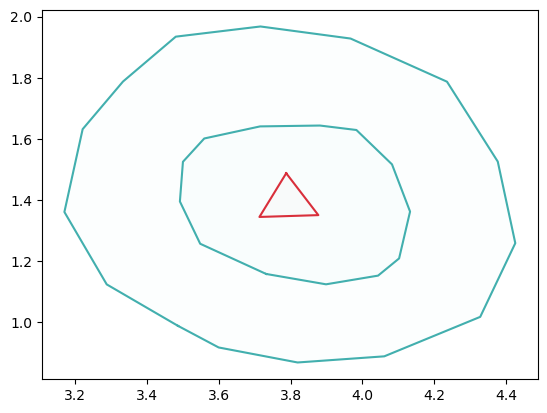

 12%|█▎        | 1/8 [00:00<00:01,  6.41it/s]

True 1 1
True 2 2
False 2 3
PolygonPolygon False


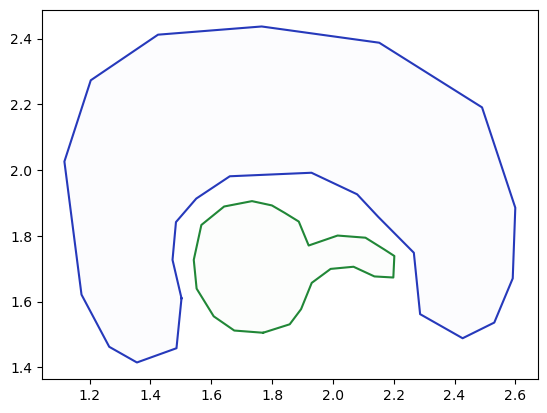

 38%|███▊      | 3/8 [00:00<00:00,  7.77it/s]

True 3 2
True 3 3
True 4 4
False 4 5
MultiPolygonPolygon False


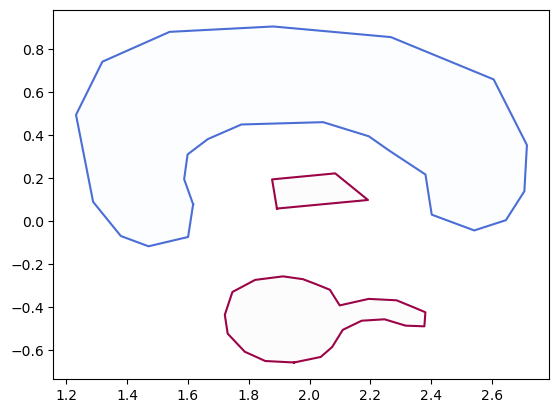

 62%|██████▎   | 5/8 [00:00<00:00,  9.72it/s]

True 5 4
True 5 5
True 6 6
False 6 7
PolygonPolygon False


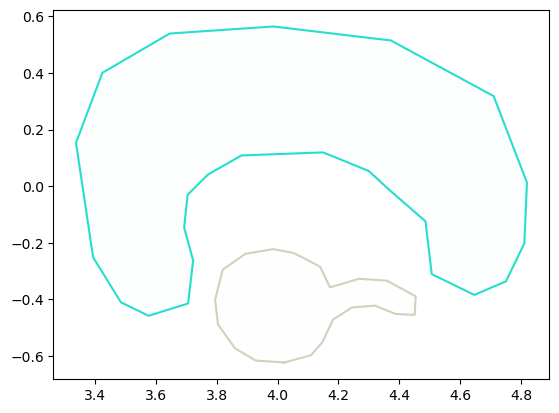

100%|██████████| 8/8 [00:00<00:00, 10.25it/s]

True 7 7
Total number intersects: 0, false: 4
Avg vertex count true: nan, false: 23.25



/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
import bench_utils
import shapely
from shapely.geometry import shape
from tqdm import tqdm
from intersection.plotting import *
import matplotlib.pyplot as plt
import json
import geopandas as gpd

intersections = []
nbr_intersects = 0
nbr_false = 0
vertices = [[], []]

def append_data_set(file_name, intersections, PRINT_AND_DRAW=True):
    global nbr_intersects
    global nbr_false
    #df, _ = bench_utils.read_dataset(file_name)
    df = gpd.read_file(file_name)
    # Add an index row
    df = df.reset_index()
    shp_cnt = len(df)

    for i in tqdm(range(shp_cnt), disable=False):
        #shp_1 = shape(df.iloc[i])
        shp_1 = df.iloc[i].geometry
        x_l_1, y_b_1, x_r_1, y_t_1 = shp_1.bounds
        from shapely.geometry import box
        shapes_within_bbox = df[df.geometry.intersects(box(x_l_1, y_b_1, x_r_1, y_t_1))]
        for _, shp_2_row in shapes_within_bbox.iterrows():
            shp_2 = shp_2_row.geometry
            if df.iloc[i]['index'] >= shp_2_row['index']:
                continue
            x_l_2, y_b_2, x_r_2, y_t_2 = shp_2.bounds
            bbox = [max(x_l_1, x_l_2), max(y_b_1, y_b_2), min(x_r_1, x_r_2), min(y_t_1, y_t_2)]
            x_l, y_b, x_r, y_t = bbox
            if x_r < x_l or y_t < y_b:
                continue

            types = [shp_1.geom_type, shp_2.geom_type]
            types.sort()
            t_1, t_2 = types
            type = t_1 + t_2
            if type == "LineStringLineString" and random.randint(0, 100) != 0:
                continue
            
            intersects = shp_1.intersects(shp_2)
            intersections += [type, shapely.to_wkt(shp_1, rounding_precision=-1), shapely.to_wkt(shp_2, rounding_precision=-1), str(intersects)]
            if intersects:
                nbr_intersects += 1
                vertices[0].append(shapely.get_num_coordinates(shp_1))
                vertices[0].append(shapely.get_num_coordinates(shp_2))
            else:
                nbr_false += 1
                vertices[1].append(shapely.get_num_coordinates(shp_1))
                vertices[1].append(shapely.get_num_coordinates(shp_2))
            if PRINT_AND_DRAW:
                print(type, intersects)
                plot_geometry(shp_1)
                plot_geometry(shp_2)
                plt.show()


#append_data_set("QGIS/Intersection_Tricky_Cases.shp", intersections, PRINT_AND_DRAW=False)
#append_data_set("data/lund_building_highway.json", intersections, False)
#append_data_set("data/world.json", intersections, False)
#append_data_set("data/china-latest-free/gis_osm_water_a_free_1.shp", intersections, False)
append_data_set("QGIS/Report_Visualizations.shp", intersections, PRINT_AND_DRAW=True)
print(f"Total number intersects: {nbr_intersects}, false: {nbr_false}")
print(f"Avg vertex count true: {np.average(vertices[0])}, false: {np.average(vertices[1])}")

f = open("data/intersection/latest_export.json", "w")
f.write(json.dumps(intersections))
f.close()

#print(intersections)